In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=500, n_features=3, n_informative=3,
                           n_redundant=0, n_clusters_per_class=1,
                           flip_y=0.1,  # adds a small amount of noise
                           class_sep=1.0,  # classes are separable but not too easily
                           random_state=40)

In [3]:
X

array([[-4.61464665, -3.2264618 ,  4.54404187],
       [ 0.44579932,  1.34683696,  0.6670701 ],
       [ 0.74616408,  0.36654281, -0.95794423],
       ...,
       [ 1.55322678, -0.05594705,  0.15149332],
       [-1.1087264 , -0.96182012, -0.08996034],
       [ 0.91602176,  1.53813433,  1.07871276]])

In [4]:
X.shape

(500, 3)

# Relabel the Y targets to +1/-1

In [5]:
y[y==0] = -1

# Data Preprocessing

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
'''
# Normalize features\
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Avoid division by zero
X_train[X_train == 0] = 1

X_train = (X_train - X_std) / X_std
X_test = (X_test - X_std) / X_std

# Reshaping y_train and y_test
y_train = y_train.reshape(n_train, 1)
y_test = y_test.reshape(n_test, 1) '''

'\n# Normalize featuresX_mean = np.mean(X_train, axis=0)\nX_std = np.std(X_train, axis=0)\n\n# Avoid division by zero\nX_train[X_train == 0] = 1\n\nX_train = (X_train - X_std) / X_std\nX_test = (X_test - X_std) / X_std\n\n# Reshaping y_train and y_test\ny_train = y_train.reshape(n_train, 1)\ny_test = y_test.reshape(n_test, 1) '

# Implementing Soft Margin SVM

In [7]:
def decision_function(w,x, b):
    return (np.dot(x, w) + b)

In [8]:
def hinge_loss(x, y, w, b):
    return np.maximum(0, 1 - y * decision_function(w, x, b))

In [9]:
def svm_loss(X, y, w, b, C):
    n = X.shape[0]
    margins = hinge_loss(X, y, w, b)
    reg_loss = 0.5 * np.sum(w**2)
    total_loss = reg_loss + C * np.sum(margins)

    return total_loss
    

In [10]:
def gradient(X, y, C, w, b):
    n = X.shape[0]
    XY = np.zeros(w.shape)
    Y = 0
    w_grad = np.zeros_like(w)
    b_grad = 0

    for i in range(n):
        hinge = hinge_loss(X[i], y[i], w, b)

        if (hinge != 0):
            XY += y[i]*X[i]
            Y += y[i] 
        
    w_grad = w - C*XY
    b_grad = -C*Y

    return w_grad, b_grad        
    

# Mini-Batch Gradient Descent

In [11]:
def create_batch(X, y, batch_size):
    mini_batch_list = []
    n = X.shape[0]

    data = np.column_stack((X,y))
    np.random.shuffle(data)
    no_of_batches= n // batch_size
    
    for i in range(no_of_batches):
        mini_batch = data[i*batch_size : (i+1)*batch_size]
        X_batch = mini_batch[:, :-1]
        y_batch = mini_batch[:, -1]
        mini_batch_list.append((X_batch, y_batch))
    
    if (n % batch_size != 0):
        mini_batch = data[no_of_batches * batch_size:]
        X_batch = mini_batch[:, :-1]
        y_batch = mini_batch[:, -1]
        mini_batch_list.append((X_batch, y_batch))

    return mini_batch_list

In [12]:
def mini_batch_gradient_descent(X_train, y_train, C, alpha, n_iterations, batch_size):
    hinge_losses = []
    n = X_train.shape[0]
    
    # Random Initialization
    w = np.random.randn(X_train.shape[1])
    b = np.random.randn()
    
    for i in range (n_iterations):
        mini_batch_list = create_batch(X_train, y_train, batch_size)
    
        for X_batch, y_batch in mini_batch_list:
            w_grad, b_grad = gradient(X_batch, y_batch, C, w, b)
            w = w - alpha * w_grad
            b = b - alpha * b_grad
        
        if (i % 50 == 0): # To print log loss after every 50 iterations
            current_loss = svm_loss(X_train, y_train, w, b, C)
            hinge_losses.append(current_loss)
            print("Epoch ", i, ": ", " Hinge Loss = ", current_loss)

    return w, b, hinge_losses

In [13]:
def predict(X, w, b):
    decision_vals = np.dot(X, w) + b

    predictions = np.where(decision_vals >= 0, 1, -1)

    return predictions

In [38]:
# Define the hyperparameter grids
C_values = [0.5, 1]
alpha_values = [0.02, 0.1]
n_iterations_values = [500, 2500]
batch_size_values = [16, 32]

best_params = {}
best_accuracy = float('-inf')
n_train = X_train.shape[0]

# Grid search over hyperparameters
for C in C_values:
    for alpha in alpha_values:
        for n_iterations in n_iterations_values:
            for batch_size in batch_size_values:
                # To ensure that every call to the random function will draw from the same sequence
                np.random.seed(42)
                
                # Train the model using mini-batch gradient descent
                w, b, hinge_losses = mini_batch_gradient_descent(X_train, y_train, C, alpha, n_iterations, batch_size)
                
                # Make predictions on the "test" set using the parameters
                y_pred = predict(X_test, w, b)
                
                current_accuracy = accuracy_score(y_test, y_pred)
                
                print(f"C: {C}, alpha: {alpha}, Epoch: {n_iterations}, Batch Size: {batch_size}")
                print(f"Accuracy Score: {current_accuracy}\n")
                
                # Select the best hyperparameters: if F1 ties, use higher precision
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy
                    best_params = {'C': C, 'alpha': alpha, 'n_iterations': n_iterations, 'batch_size': batch_size}

Epoch  0 :   Hinge Loss =  38.489090986533576
Epoch  50 :   Hinge Loss =  15.551002746014081
Epoch  100 :   Hinge Loss =  15.423168734119631
Epoch  150 :   Hinge Loss =  15.412527108951286
Epoch  200 :   Hinge Loss =  15.237626664770541
Epoch  250 :   Hinge Loss =  15.568878468564943
Epoch  300 :   Hinge Loss =  15.508887100249437
Epoch  350 :   Hinge Loss =  15.823840617425917
Epoch  400 :   Hinge Loss =  15.749425472904374
Epoch  450 :   Hinge Loss =  15.710058742654896
C: 0.1, alpha: 0.02, Epoch: 500, Batch Size: 16
Accuracy Score: 0.84

Epoch  0 :   Hinge Loss =  39.95145410194071
Epoch  50 :   Hinge Loss =  14.44825228250478
Epoch  100 :   Hinge Loss =  14.427232650110618
Epoch  150 :   Hinge Loss =  14.377556480622419
Epoch  200 :   Hinge Loss =  14.34346441673484
Epoch  250 :   Hinge Loss =  14.502815504213302
Epoch  300 :   Hinge Loss =  14.463251643923252
Epoch  350 :   Hinge Loss =  14.59754681256253
Epoch  400 :   Hinge Loss =  14.56602876510637
Epoch  450 :   Hinge Loss =  

In [ ]:
print("Best Hyperparameters:", best_params)

C_opt = best_params["C"] 
alpha_opt = best_params["alpha"] 
n_iterations_opt = best_params["n_iterations"] 
batch_size_opt = best_params["batch_size"] 

In [40]:
w_opt, b_opt, hinge_losses = mini_batch_gradient_descent(X_train, y_train, C_opt, alpha_opt, n_iterations_opt, batch_size_opt)

print("Optimal w: \n")
print(w_opt)

print("\nOptimal b: \n")
print(b_opt)

Epoch  0 :   Hinge Loss =  78.74978639024074
Epoch  50 :   Hinge Loss =  65.18613613891819
Epoch  100 :   Hinge Loss =  64.2188374074107
Epoch  150 :   Hinge Loss =  64.58572974709033
Epoch  200 :   Hinge Loss =  64.55957885348236
Epoch  250 :   Hinge Loss =  66.03198114427562
Epoch  300 :   Hinge Loss =  63.289860166451064
Epoch  350 :   Hinge Loss =  65.544266253704
Epoch  400 :   Hinge Loss =  65.19835455513412
Epoch  450 :   Hinge Loss =  64.58758618410484
Epoch  500 :   Hinge Loss =  66.79601022937176
Epoch  550 :   Hinge Loss =  65.57960413490726
Epoch  600 :   Hinge Loss =  64.47729421475118
Epoch  650 :   Hinge Loss =  65.05354263366408
Epoch  700 :   Hinge Loss =  64.3705990738367
Epoch  750 :   Hinge Loss =  64.92894917120614
Epoch  800 :   Hinge Loss =  66.08060196331391
Epoch  850 :   Hinge Loss =  65.97495824479903
Epoch  900 :   Hinge Loss =  63.86943023910243
Epoch  950 :   Hinge Loss =  64.80000377565234
Epoch  1000 :   Hinge Loss =  65.85014707290763
Epoch  1050 :   Hi

# Model Evaluation

In [41]:
y_pred = predict(X_test, w_opt, b_opt)

In [42]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.9


# Visualizing the Training Data & Decision Boundary in 3D

In [43]:
x_vals = np.linspace(np.min(X_train[:, 0]), np.max(X_train[:, 0]), 50)
y_vals = np.linspace(np.min(X_train[:, 1]), np.max(X_train[:, 1]), 50)
labels = y_train.flatten()

X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)

Z_mesh = (-w_opt[0] * X_mesh - w_opt[1] * Y_mesh - b_opt) * 1. / w_opt[2]

In the following plot, red dots represent class +1, whereas blue dots represent class -1.

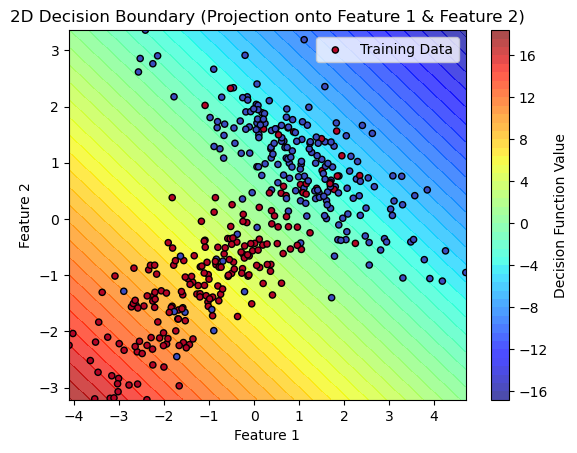

In [44]:
fig = plt.figure()

contour = plt.contourf(X_mesh, Y_mesh, Z_mesh, levels = 50, cmap = 'jet', alpha = 0.7)
plt.colorbar(contour, label='Decision Function Value')
plt.scatter(X_train[:, 0], X_train[:, 1], c = labels, cmap = 'coolwarm', edgecolors = 'k', s = 20, label = 'Training Data')

plt.title('2D Decision Boundary (Projection onto Feature 1 & Feature 2)')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

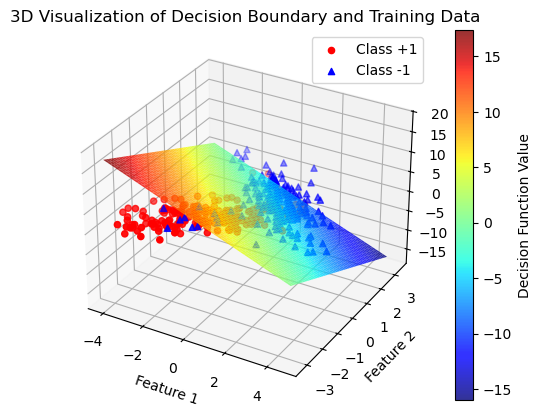

In [45]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

surface = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap = "jet", alpha = 0.8)
ax.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], X_train[labels == 1, 2], c = 'r', marker = 'o', s = 20, label = 'Class +1')
ax.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], X_train[labels == -1, 2], c = 'b', marker = '^', s = 20, label = 'Class -1')

fig.colorbar(surface, label='Decision Function Value')
ax.set_title('3D Visualization of Decision Boundary and Training Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
plt.show()

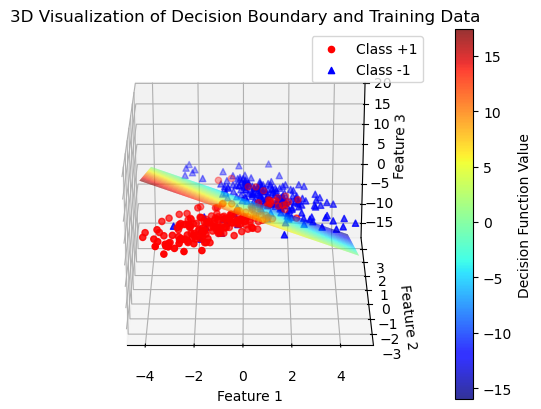

In [46]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

surface = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap = "jet", alpha = 0.8)
ax.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], X_train[labels == 1, 2], c = 'r', marker = 'o', s = 20, label = 'Class +1')
ax.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], X_train[labels == -1, 2], c = 'b', marker = '^', s = 20, label = 'Class -1')

fig.colorbar(surface, label='Decision Function Value')
ax.set_title('3D Visualization of Decision Boundary and Training Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

ax.view_init(elev=25, azim=-90)
ax.legend()
plt.show()

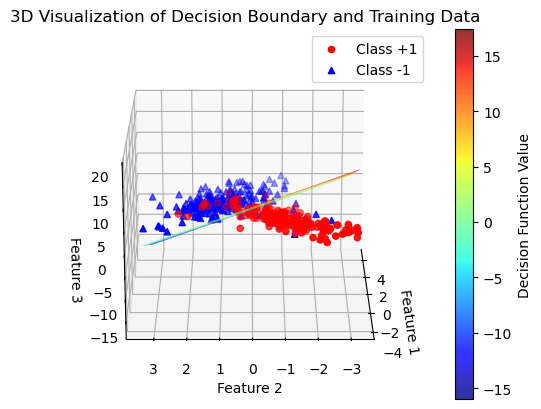

In [47]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

surface = ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap = "jet", alpha = 0.8)
ax.scatter(X_train[labels == 1, 0], X_train[labels == 1, 1], X_train[labels == 1, 2], c = 'r', marker = 'o', s = 20, label = 'Class +1')
ax.scatter(X_train[labels == -1, 0], X_train[labels == -1, 1], X_train[labels == -1, 2], c = 'b', marker = '^', s = 20, label = 'Class -1')

fig.colorbar(surface, label='Decision Function Value')
ax.set_title('3D Visualization of Decision Boundary and Training Data')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

ax.view_init(elev = 20, azim = -180)
ax.legend()
plt.show()

# Plotting Hinge Loss Over Iterations

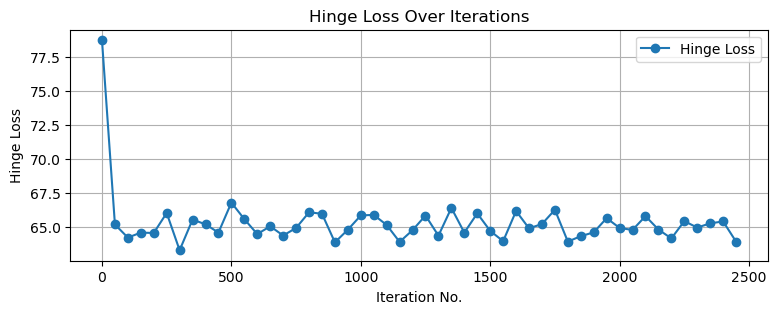

In [48]:
plt.figure(figsize = (9,3))
plt.title("Hinge Loss Over Iterations")
plt.xlabel("Iteration No.")
plt.ylabel("Hinge Loss")
plt.plot(range(0, len(hinge_losses)*50, 50), hinge_losses, marker = 'o', label = "Hinge Loss")
plt.grid(True)
plt.legend()
plt.show()